In [11]:
import altair as alt
import pandas as pd
from altair import datum
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import HTML, Markdown as md
alt.data_transformers.disable_max_rows()
from src.data.read_dataset import get_processed_dataset
from src.visualization import visualize as viz

prov_df = get_processed_dataset('dpc_province')
prov = prov_df.groupby('provincia').nth(-1).reset_index()


In [2]:
def todays_bars(field, title='Nuovi positivi oggi'):
    return alt.Chart(prov).transform_window(
        rank='rank(field)',
        sort=[alt.SortField(field, order='descending')]
    ).transform_filter(
        alt.datum.rank < 20
    ).mark_bar().encode(
        x=field,
        y=alt.Y('provincia:N', sort='-x'),
        color=alt.Color('regione:N')
    ).properties(
        height=600,
        width=800
    ).properties(title=title + ', ' + str(prov.data.iloc[0])).interactive()

In [3]:
todays_bars('nuovi_positivi')

alt.Chart(...)

In [4]:
todays_bars('nuovi_positivi_per_1M_pop', title='Nuovi positivi per 1M abitanti oggi')

alt.Chart(...)

In [16]:
start_date = prov_df.data.max() - pd.Timedelta(days=7)
last_week = prov_df[prov_df.data > start_date]
last_grouped = last_week.groupby(['provincia', 'codice_provincia', 'codice_regione', 'regione']).mean().reset_index()

alt.Chart(last_grouped).transform_window(
    rank='rank(nuovi_positivi_per_1M_pop)',
    sort=[alt.SortField('nuovi_positivi_per_1M_pop', order='descending')]
).transform_filter(
    alt.datum.rank < 20
).mark_bar().encode(
    x='nuovi_positivi_per_1M_pop:Q',
    y=alt.Y('provincia:N', sort='-x'),
    color=alt.Color('regione:N')
).properties(
    height=600,
    width=800,
    title='Nuovi casi per 1M pop per provincia - Media ultimi 7 giorni'
)

alt.Chart(...)

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
italy = gpd.read_file('../../data/raw/prov2019.geojson')

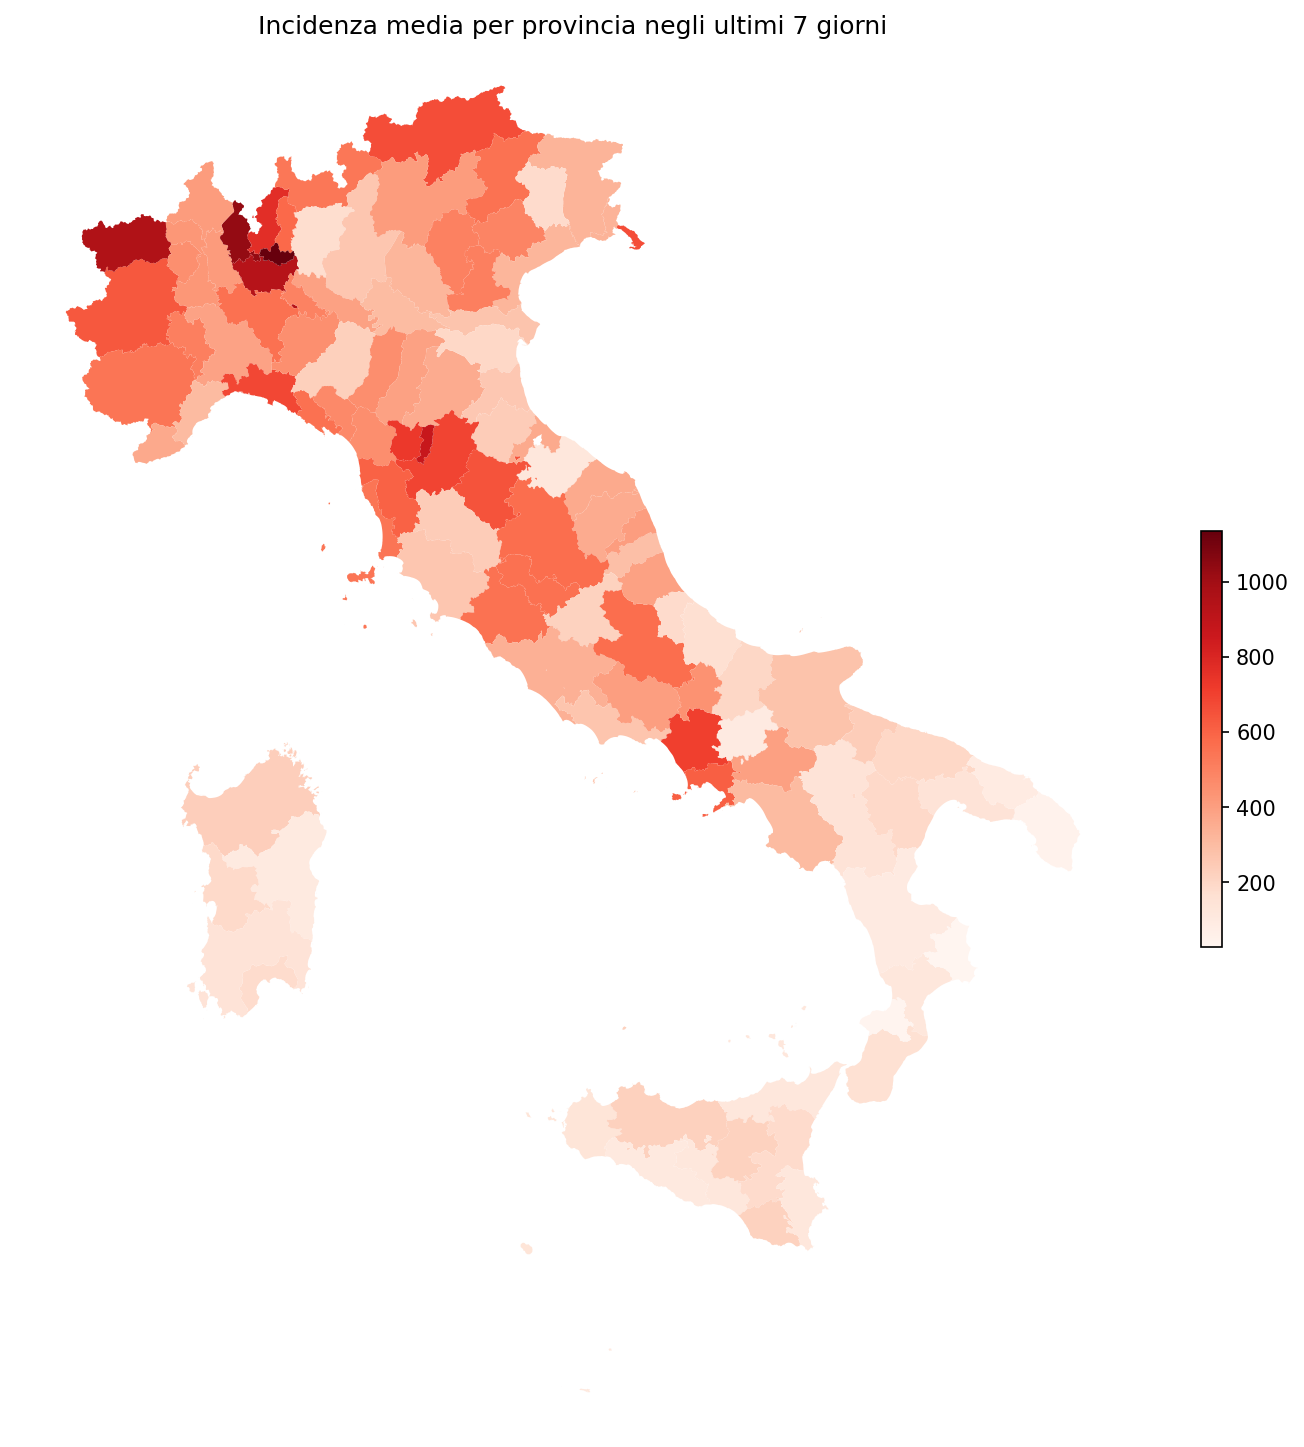

In [7]:
merged = pd.merge(italy, last_grouped, left_on="COD_PROV", right_on="codice_provincia")
f, ax = plt.subplots(1, figsize=(12,12))
merged.plot(column='nuovi_positivi_per_1M_pop', ax=ax, cmap='Reds', legend=True, legend_kwds={'shrink': 0.3})
ax.set_axis_off()
plt.axis('equal')
plt.title('Incidenza media per provincia negli ultimi 7 giorni')
plt.show()

In [8]:
alt.Chart(prov).transform_window(
    rank='rank(totale_casi_per_1M_pop)',
    sort=[alt.SortField('totale_casi_per_1M_pop', order='descending')]
).transform_filter(
    alt.datum.rank < 30
).mark_bar().encode(
    x='totale_casi_per_1M_pop:Q',
    y=alt.Y('provincia:N', sort='-x'),
    color=alt.Color('regione:N')
).properties(
    height=600,
    width=800,
    title='Totale casi per 1M pop per provincia'
)

alt.Chart(...)

In [14]:
top_codes = prov.sort_values(by='totale_casi_per_1M_pop').tail(49).codice_provincia

prov_top = prov_df[prov_df.codice_provincia.isin(top_codes)]

In [15]:
base = alt.Chart().transform_window(
    averaged='mean(nuovi_positivi_per_1M_pop)',
    frame=[-4,3],
    groupby=['provincia']
).encode(
    x='data:T',
    tooltip=['provincia'],
    color=alt.Color('regione:N')
).properties(
    height=150,
    width=150,
)

c1 = base.mark_line().encode(
    y=alt.Y('averaged:Q', title=''),
)

c2 = base.mark_bar(opacity=0.1).encode(
    y=alt.Y('nuovi_positivi_per_1M_pop', title='', scale=alt.Scale(domain=(0, 1500))),

)

alt.layer(c1, c2, data=prov_top).facet(facet='provincia:N', columns=7).properties(
    title={
      "text": ['Casi per 1M abitanti'], 
      "subtitle": ["Dato mediato su 7 giorni"]
    }
).interactive()

alt.FacetChart(...)